In [1]:
import sncosmo
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from pandas import read_csv
from scipy.integrate import cumulative_trapezoid as cumtrapz
import astropy.constants as co
import astropy.units as u
import astropy.cosmology.units as cu
from scipy import interpolate
from astropy.cosmology import WMAP9 as cosmo
import extinction
import math
import scipy.stats as stats
from scipy.interpolate import CubicSpline
import time


DAY_CGS = u.day
M_SUN_CGS = co.M_sun
C_CGS = co.c
beta = 13.7
KM_CGS = u.km

STEF_CONST = 4. * np.pi * co.sigma_sb
ANG_CGS = u.Angstrom
MPC_CGS = u.Mpc

DIFF_CONST = 2.0 * M_SUN_CGS / (beta * C_CGS * KM_CGS)
TRAP_CONST = 3.0 * M_SUN_CGS / (4. * np.pi * KM_CGS ** 2)
FLUX_CONST = 4.0 * np.pi * (
        2.0 * co.h * co.c ** 2 * np.pi) * u.Angstrom
X_CONST = (co.h * co.c / co.k_B)

In [2]:
ibc_df = read_csv("merged_ibc_with_redshift.csv")
ia_df = read_csv("merged_modelpar_Ia_with_redshift.csv")

In [3]:
ibc_df.head()

,object_id,true_z,submodel,sim_av,IBC_INDEX,Mejecta,Kinetic_energy,F_nickel
0,268,0.621,2,0.1007,569,4.0460,1.3293,0.0744
1,1304,0.309,2,0.8308,577,6.1297,2.4682,0.0565
2,1660,0.817,2,0.0018,670,9.8119,4.1647,0.0849
3,2407,0.586,2,0.0108,500,1.1125,7.1842,0.0801
4,3073,0.441,2,0.2936,395,2.0126,3.4670,0.0448


In [4]:
class ArnettSource(sncosmo.Source):

    _param_names = ['texp', 'mej', 'fni', 'vej']
    param_names = ['texp', 'mej', 'fni', 'vej']

    param_names_latex = ['t_{exp}', 'M_{ej}', 'f_{Ni}', 'v_{ej}']   # used in plotting display

    def __init__(self, phase, wave, redshift,  params=None, name=None, version=None):
        
        self.name = name
        self.version = version
        self._phase = phase
        self._wave = wave
        self._z = redshift
        # self._texp = texp
        self._tfloor = 3000 * u.K
        if params is not None:
            self._parameters = params
        else:
            self._parameters = [0, 0, 0, 0]

    def _blackbody_flux(self, temperature, radius, wavelength):
        # Convert wavelength from Angstrom to cm

        all_fluxes = np.zeros((len(temperature), len(wavelength))) * (u.erg / (u.s * u.AA)).decompose()
        for i in range(len(temperature)):
            temp = temperature[i]
            rad = radius[i]

            # Planck function numerator: 2hc^2 / λ^5
            numerator = (2 * co.h * co.c**2 / wavelength**5).decompose()

            # Exponent of the Planck function
            exponent = (co.h * co.c / (wavelength * co.k_B * temp)).decompose()

            # Compute denominator, stripping unit to pass into np.exp safely
            denominator = np.exp(exponent.value) - 1

            # Spectral radiance: Planck's law in SI units (W / (m^2 m))
            flux_density = numerator / denominator

            # Convert to flux at the source: multiply by 4πR²
            flux_final = flux_density * (4 * np.pi * rad**2)

            # Assign to all_fluxes
            all_fluxes[i, :] = flux_final
        return all_fluxes 


    def _gen_arnett_model(self, t, wvs, redshift, theta):
        texp, mej, fni, vej = theta
        mej = (mej * u.Msun).to(u.g)
        vej = vej * u.km/u.s
        t = t * u.day
        wvs = wvs * u.AA
        tfloor = self._tfloor
        mni = mej * fni
        # Convert velocity to cm/s
        vej = vej.to(u.cm / u.s)

        tni = 8.8 * u.day  # days
        tco = 111.3  * u.day # days
        epco = 6.8e9 * u.erg / u.g / u.s # erg/g/s
        epni = 3.9e10 * u.erg / u.g / u.s # erg/g/s
        opac = 0.1 *u.cm * u.cm/u.g        
        texp = texp * u.day

        # Diffusion timescale in days
        td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
        # print(mej.to(u.Msun), vej, td)
        # if td < 3. * u.day:
        #     td = 3. * u.day
        # print(td)

        # use a denser time array for better integration
        t_to_integrate = np.linspace(0, np.max(t - texp), 1000)
        
        # td = np.sqrt(2 * opac * mej / (13.7 * C_CGS * vej)) / 86400  # convert seconds to days
        integrand1 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tni)
        integrand2 = (t_to_integrate / td) * np.exp(t_to_integrate**2 / td**2 - t_to_integrate / tco)

        # Luminosity calculation
        dense_luminosities = 2 * mni / (td) * np.exp(-t_to_integrate**2 / td**2) * \
              (((epni - epco) * cumtrapz(integrand1, t_to_integrate, initial=0) + 
               epco * cumtrapz(integrand2, t_to_integrate, initial=0)))*u.day # these should be erg/s
        
        spline = CubicSpline(t_to_integrate, dense_luminosities, extrapolate = False)
        luminosities = spline(t - texp) * u.erg / u.s # interpolate back from dense time array to original time points

        #Do BB calculation
        radius = (vej * ((t - texp) * ((t-texp)>=0))).to(u.cm)

        temperature = ((luminosities / (STEF_CONST * radius**2))**0.25).to(u.K)# * (1e52)**0.25
        gind = (temperature < tfloor) | np.isnan(temperature)
        temperature = np.nan_to_num(temperature)
        notgind = np.invert(gind)
        temperature = (0. * temperature) + (temperature * notgind) + (tfloor * gind)
        
        radius = np.sqrt(luminosities / (STEF_CONST * temperature**4))
        radius = radius.to(u.cm)

        fluxes = self._blackbody_flux(temperature, radius, wvs) # this is a luminosity density
        fluxes[t < texp,:] = 0.* u.kg *u.m / u.s**3

        
        # divide luminosity density by 4pir^2 to get flux
        z = redshift * cu.redshift
        d_cm = z.to(u.cm, cu.redshift_distance(cosmo, kind="luminosity"))
        flux_density = fluxes / (4 * np.pi * d_cm**2) 
        return flux_density


    def _flux(self, phase, wave):
        return self._gen_arnett_model(phase, wave, self._z, self._parameters)

In [5]:
times = np.linspace(0.1,100,100) # days
wavelengths = np.linspace(2000,12000,10) # Angstroms
# texp = 5

num_points = 10
time_points = np.linspace(0.01,100, num_points) # to observe
num_points = len(time_points)
# bands = ['lsstu', 'lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']

# bands = ['lsstg', 'lsstr', 'lssti', 'lsstz', 'lssty']
bands = ['lsstg', 'lsstr', 'lssti', 'lsstz']



# zeropoints from https://smtn-002.lsst.io/
# zeropoints = [26.52, 28.51, 28.36, 28.17, 27.78, 26.82]
# zeropoints = [28.51, 28.36, 28.17, 27.78, 26.82]
zeropoints = [28.51, 28.36, 28.17, 27.78]


num_bands = len(bands)

ibc_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':1.*np.ones(num_points*num_bands)})

ia_obs = Table({'time': list(time_points) * num_bands,
             'band': np.repeat(bands, num_points),
            'zp': np.repeat(zeropoints, num_points), 'zpsys':['ab']*num_points*num_bands, 
             'gain':np.ones(num_points*num_bands), 'skynoise':100.*np.ones(num_points*num_bands)})

In [6]:
def simulate_ibc(true_z, texp, mej, fni, vej):
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[mej, fni, vej])
    arnett_source = ArnettSource(times, wavelengths, true_z, params=[texp, mej, fni, vej])

    
    arnett_model = sncosmo.Model(source=arnett_source)
    params = {'texp': texp, 'mej': mej, 'fni': fni, 'vej': vej}

    lcs = sncosmo.realize_lcs(ibc_obs, arnett_model, [params])
    
    r_band_mask = lcs[0]['band'] == 'lsstr'

    
    # calculate SNR in r band
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)
    # mej = (mej * u.Msun).to(u.g)
    # vej = vej * u.km/u.s
    # opac = 0.1 *u.cm * u.cm/u.g        

    # Diffusion timescale in days
    # td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day)   # convert seconds to days
    # print(td)
    # lcs[0]['flux'][lcs[0]['flux'] <= 0] = 0.1
    return lcs

SNR: 5.714158677486013


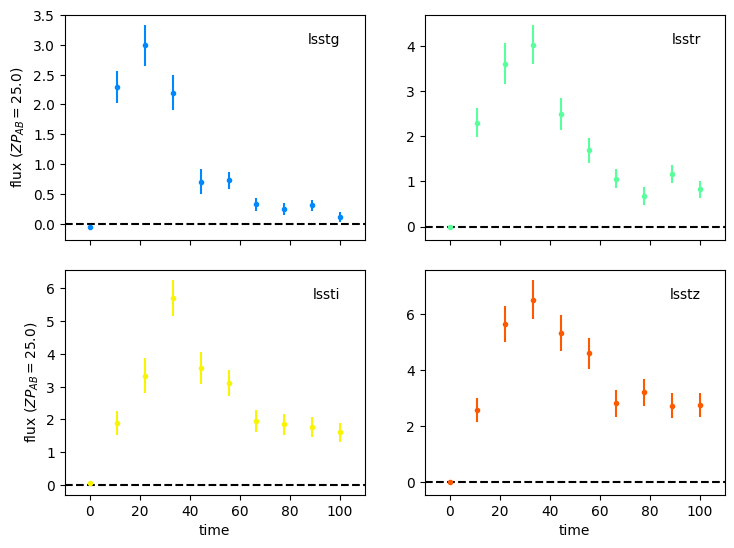

In [7]:
# light_curve = simulate_ibc(0.05, 0, 3, 0.1, 10000)
# light_curve = simulate_ibc(0.116, 5.76, 0.4841, 0.0309, 37270.73384139233)
# light_curve = simulate_ibc(0.116, 2.4, 0.4841, 0.0309, 37270.73384139233)

light_curve = simulate_ibc(0.18, 0, 5.4863 , 0.0456, 10416.298485236222)


sncosmo.plot_lc(light_curve[0]);

In [8]:
def get_texp_guess(light_curve):
    max_index = np.argmax(light_curve[0]['flux'][light_curve[0]['band'] == 'lssti'])
    print(max_index)
    max_time = (light_curve[0]['time'][light_curve[0]['band'] == 'lssti'])[max_index]
    print((light_curve[0]['time'][light_curve[0]['band'] == 'lssti']))
    print(max_time)
    return max_time - 5.

In [9]:
def fit_ibc(true_z, lcs):

    arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 3, 0.05, 15000]) # initial parameter values? not sure why these are needed...
    # arnett_source = ArnettSource(times, wavelengths, true_z, params=[ mej, fni, vej])

    arnett_model = sncosmo.Model(source=arnett_source)

    try:
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                          bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                         minsnr = 5.0, guess_t0 = True, guess_z = False, guess_amplitude=False)
    except:
        print("Trying again...")
        arnett_source = ArnettSource(times, wavelengths, true_z, params=[5, 0.5, 0.1, 20000]) # initial parameter values? not sure why these are needed...
        arnett_model = sncosmo.Model(source=arnett_source)
        result, fitted_model = sncosmo.fit_lc(lcs[0], arnett_model, ['texp', 'mej', 'fni', 'vej'], 
                                  bounds={'texp':(0, 14), 'mej':(0.01, 10), 'fni':(0.01, 1), 'vej':(2000, 20000)},
                                 minsnr = 5.0, guess_t0 = False, guess_z = False, guess_amplitude=False)
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [10]:
def td(mej, vej):
    mej = (mej * u.Msun).to(u.g)
    vej = vej * u.km/u.s
    # Diffusion timescale in days
    opac = 0.1 *u.cm * u.cm/u.g        
    td = np.sqrt(2 * opac * mej / (13.7 * co.c * vej)).to(u.day) 
    return td

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/iminuit/util.py:177: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


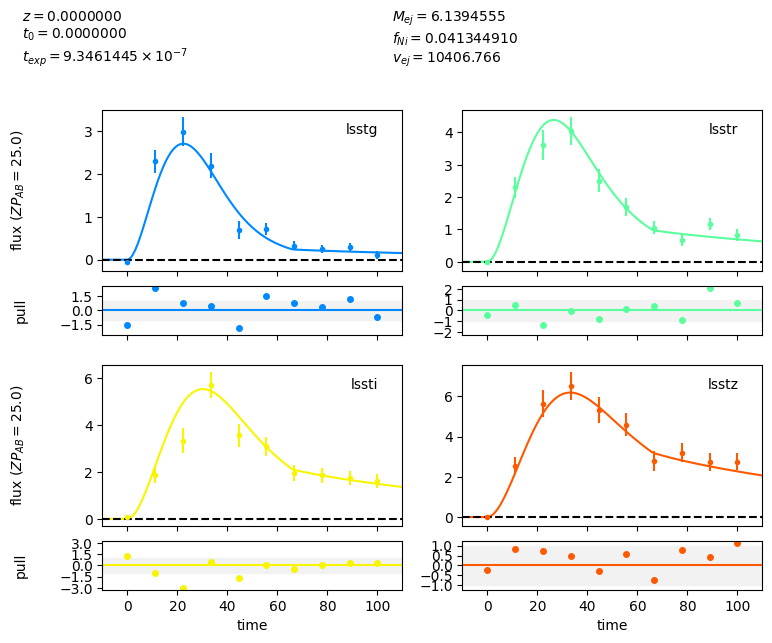

In [11]:
result, fitted_model = fit_ibc(0.18, light_curve)
sncosmo.plot_lc(light_curve[0], model=fitted_model);

In [12]:
num_to_fit = 10
fits = {'true_z': [], 'true_texp': [], 'true_mej': [], 'true_fni': [], 'true_vej':[], 'fit_texp':[], 'fit_mej':[], 'fit_fni':[], 'fit_vej':[]}

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = ((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)
    
    this_texp = np.random.uniform(0., 7.)
    if true_z > 0.2 or vej.value > 20000:
        continue
    
    print(true_z, this_texp)

    print(mej, fni, vej)
    try:
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej.value)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask]) 
        if snr < 5.0:
            print("SNR too low:", snr)
            continue
        # sncosmo.plot_lc(lcs[0])

        result, fitted_model = fit_ibc(true_z, lcs)
        # sncosmo.plot_lc(lcs[0], model=fitted_model)
        # plt.show()
        result_dict = sncosmo.flatten_result(result)
        fits['true_z'].append(true_z)
        fits['true_texp'].append(this_texp)
        fits['true_mej'].append(mej)
        fits['true_fni'].append(fni)
        fits['true_vej'].append(vej.value)
        fits['fit_texp'].append(result_dict['texp'])
        fits['fit_mej'].append(result_dict['mej'])
        fits['fit_fni'].append(result_dict['fni'])
        fits['fit_vej'].append(result_dict['vej'])
    except Exception as e:
        print(e)

    if len(fits['fit_mej']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.168 0.7298731999620407
9.8016 0.0245 9565.13884330619 km / s
SNR: 5.557789040071818


/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in power
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Trying again...
0.173 5.455522713287528
1.904 0.0166 16348.990983769314 km / s
SNR: 1.4113764082384246
SNR too low: 1.4113764082384246
0.187 6.337038039259361
1.0118 0.0617 15126.84991592506 km / s
SNR: 2.6418686533276547
SNR too low: 2.6418686533276547
0.195 4.555296896797461
7.6253 0.0184 4905.6166488100735 km / s
SNR: 3.6000348842136374
SNR too low: 3.6000348842136374
0.095 1.8245301160150222
2.5761 0.0146 15028.819140533313 km / s
SNR: 3.5290341417270428
SNR too low: 3.5290341417270428
0.17 1.8990622765431873
1.7163 0.0156 14248.0156368035 km / s
SNR: 2.0809783122032908
SNR too low: 2.0809783122032908
0.175 2.451733166901543
7.9896 0.0192 7171.612516212528 km / s
SNR: 4.3726177427482735
SNR too low: 4.3726177427482735
0.18 3.8456523369485174
5.4863 0.0456 10416.298485236222 km / s
SNR: 5.444791310980202
0.184 6.764840597140088
9.8016 0.0245 9565.13884330619 km / s
SNR: 4.753414201315584
SNR too low: 4.753414201315584
0.174 6.309245792722962
7.124 0.0112 7986.630416412141 km / s
SNR

Text(0, 0.5, 'Fit texp')

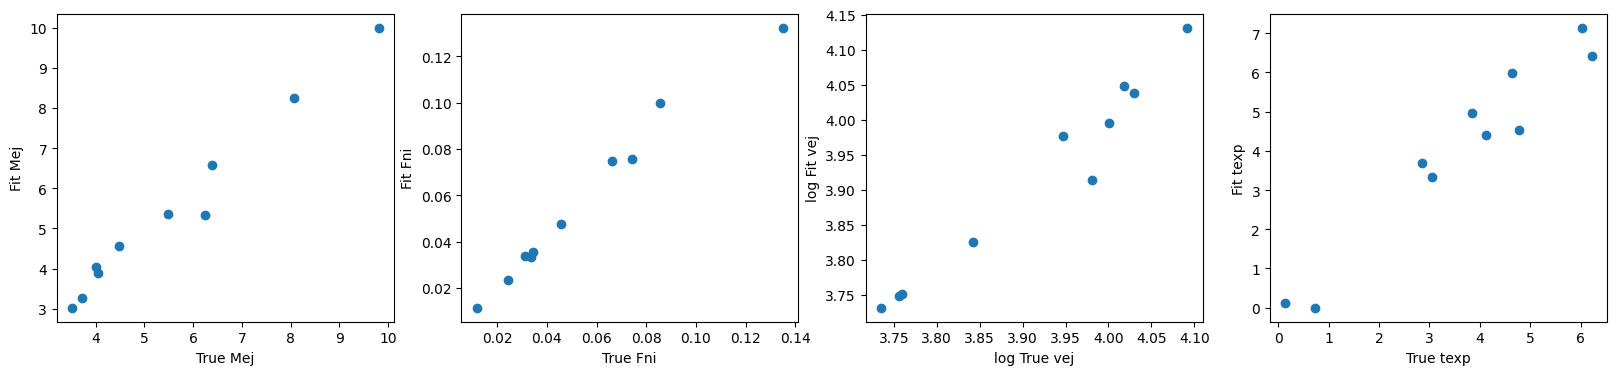

In [13]:
fig, ax = plt.subplots(1,4, figsize=(20, 4))

ax[0].plot(fits['true_mej'], fits['fit_mej'], 'o')
ax[0].set_xlabel("True Mej")
ax[0].set_ylabel("Fit Mej")
ax[1].plot(fits['true_fni'], fits['fit_fni'], 'o')
ax[1].set_xlabel("True Fni")
ax[1].set_ylabel("Fit Fni")
ax[2].plot(np.log10(fits['true_vej']), np.log10(fits['fit_vej']), 'o')
ax[2].set_xlabel("log True vej")
ax[2].set_ylabel("log Fit vej")
ax[3].plot(fits['true_texp'], fits['fit_texp'], 'o')
ax[3].set_xlabel("True texp")
ax[3].set_ylabel("Fit texp")

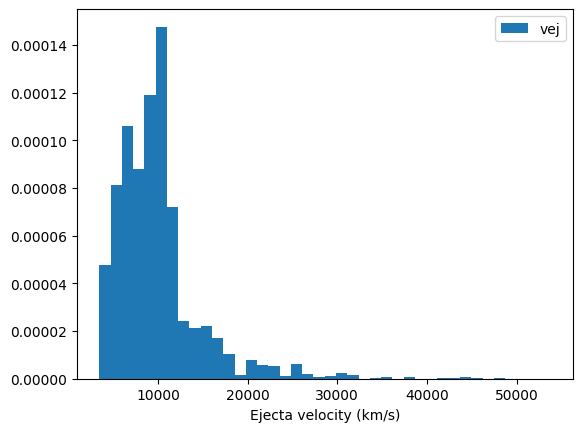

In [14]:
vej = np.sqrt(
    2 * ibc_df['Kinetic_energy'].values * 1e51 * u.erg / (ibc_df['Mejecta'].values * u.Msun)
)
vej = vej.to(u.km / u.s)
plt.hist(vej.value, bins=40, density=True, label="vej")
plt.xlabel("Ejecta velocity (km/s)")
plt.legend()


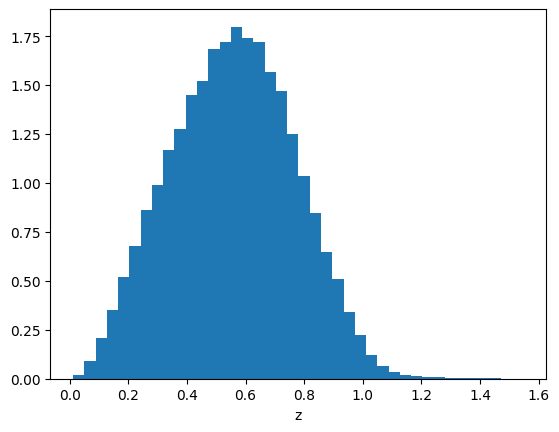

In [15]:
plt.hist(ia_df['true_z'].to_numpy(), bins=40, density=True)
plt.xlabel("z")
plt.show()

In [16]:
def get_x0(mb):
    return 10**(-(mb-10.635)/2.5)

In [17]:
get_x0(np.min(ia_df['salt2_mb'].to_numpy())), get_x0(np.max(ia_df['salt2_mb'].to_numpy()))

(0.047363086913163675, 7.842959998847406e-07)

In [18]:
np.min(ia_df['salt2_color'].to_numpy()), np.max(ia_df['salt2_color'].to_numpy())

(-0.2673, 0.3732)

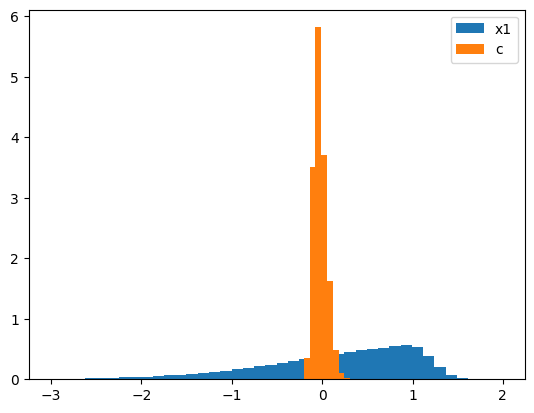

In [19]:
plt.hist(ia_df['salt2_x1'].to_numpy(), bins=40, density=True, label="x1")
plt.hist(ia_df['salt2_color'].to_numpy(), density=True, label="c")
plt.legend()

In [20]:
def simulate_ia(true_z, t0, x0, x1, c):
    params = {'z': true_z, 't0': t0, 'x0':x0, 'x1': x1, 'c':c}
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)

    lcs = sncosmo.realize_lcs(ia_obs, this_ia_model, [params])
    snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask])
    print("SNR:", snr)

    return lcs

In [21]:
def fit_ia(true_z, lcs):

    # this_ia_model = sncosmo.Model(source='salt2')
    
    ia_source = sncosmo.get_source('salt2', version='B22')
    
    this_ia_model = sncosmo.Model(source=ia_source)
    
    this_ia_model.set(z = true_z)
    
    result, fitted_model = sncosmo.fit_lc(lcs[0], this_ia_model,
    ['t0', 'x0', 'x1', 'c'], minsnr = 1., guess_z = False, bounds={'x0':(0, 0.1), 'x1':(-3, 2), 'c':(-1, 1)})
    
    # return sncosmo.flatten_result(result)
    return result, fitted_model

In [22]:
# light_curve = simulate_ia(0.624, 20, get_x0(23.7568), -0.3504, 0.0744)
light_curve = simulate_ia(0.2, 20, get_x0(23.7568), -0.3504, 0.0744)

SNR: 0.9854739122101881


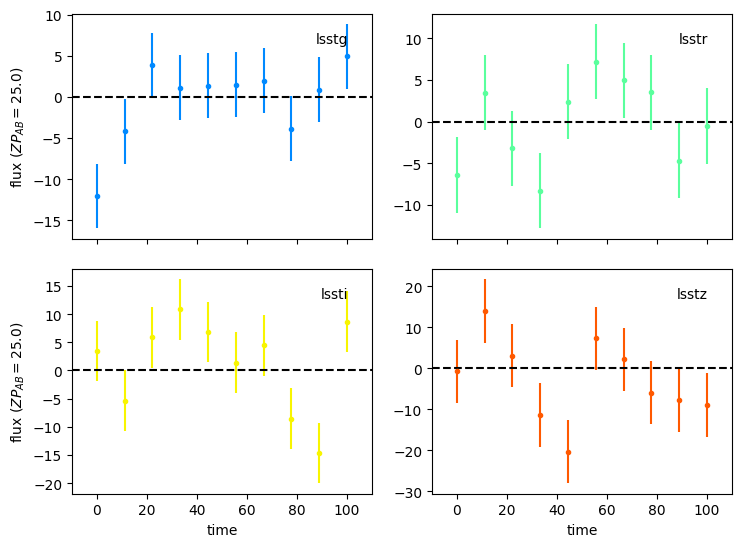

In [23]:
sncosmo.plot_lc(light_curve[0]);

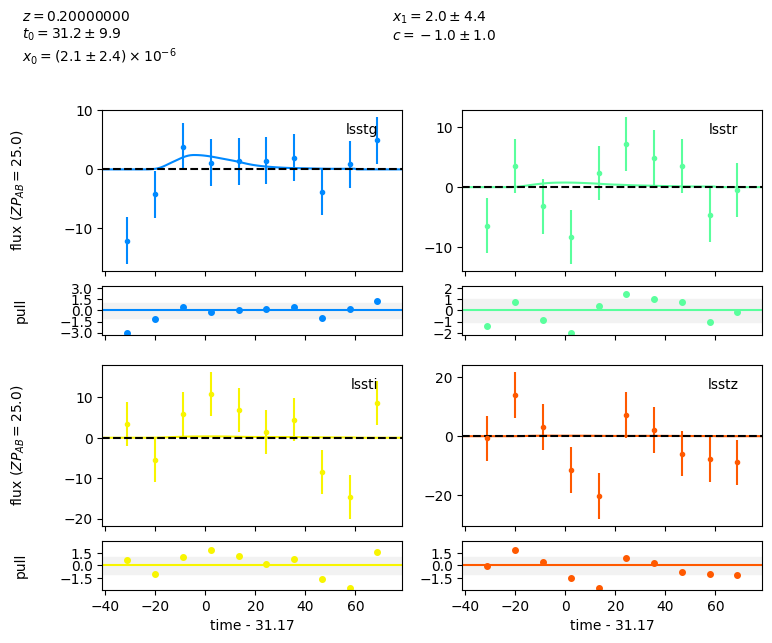

In [24]:
ia_result, ia_fitted_model = fit_ia(0.2,light_curve)
# ibc_result, ibc_fitted_model = fit_ibc(0.274,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

SNR: 5.427553001587645


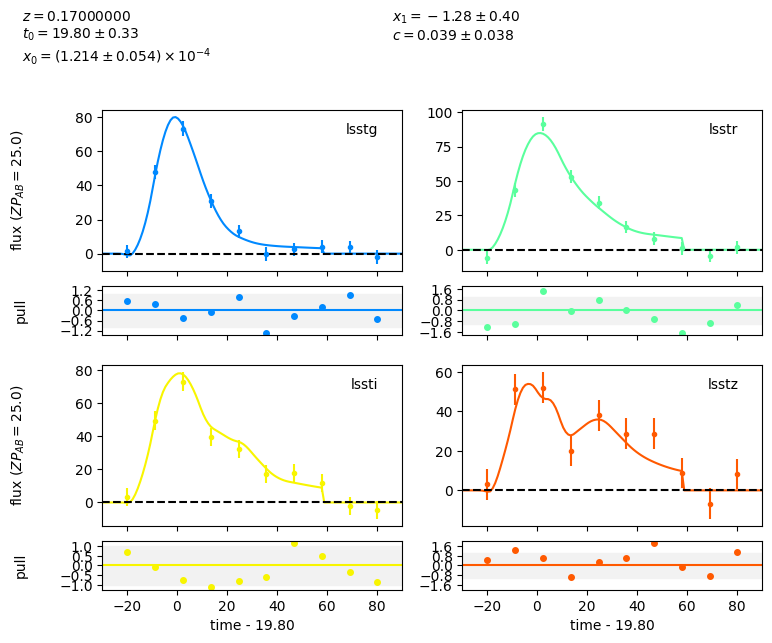

In [25]:
light_curve = simulate_ia(0.17, 20, get_x0(20.3969), -1.3166, 0.0048)
ia_result, ia_fitted_model = fit_ia(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

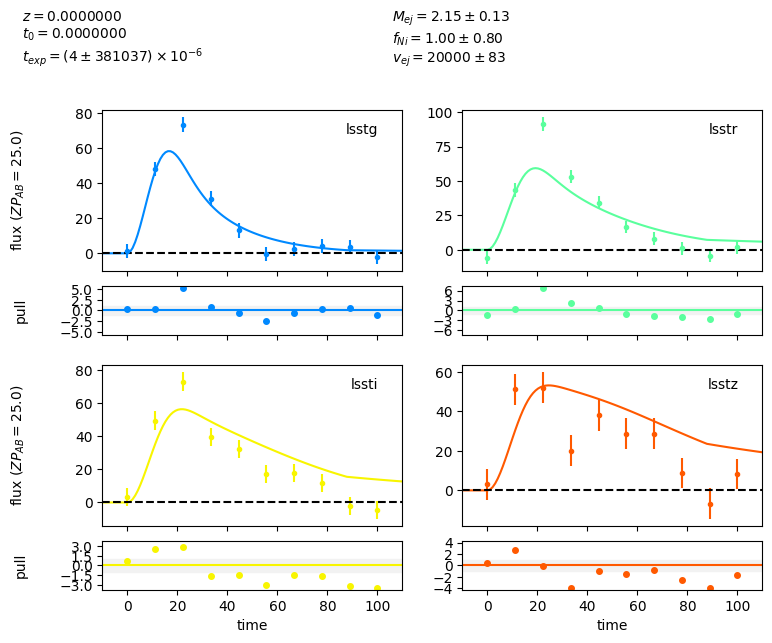

In [26]:
ibc_result, ibc_fitted_model = fit_ibc(0.17,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

SNR: 3.696720645053481


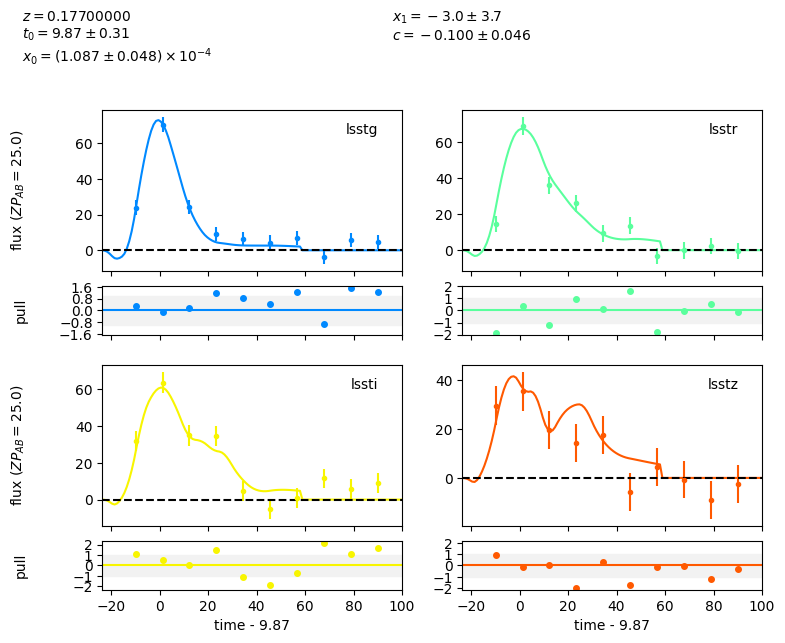

In [27]:
light_curve = simulate_ia(0.177, 10, get_x0(20.5669), -2.872, -0.0432)
ia_result, ia_fitted_model = fit_ia(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ia_fitted_model, errors=ia_result.errors);

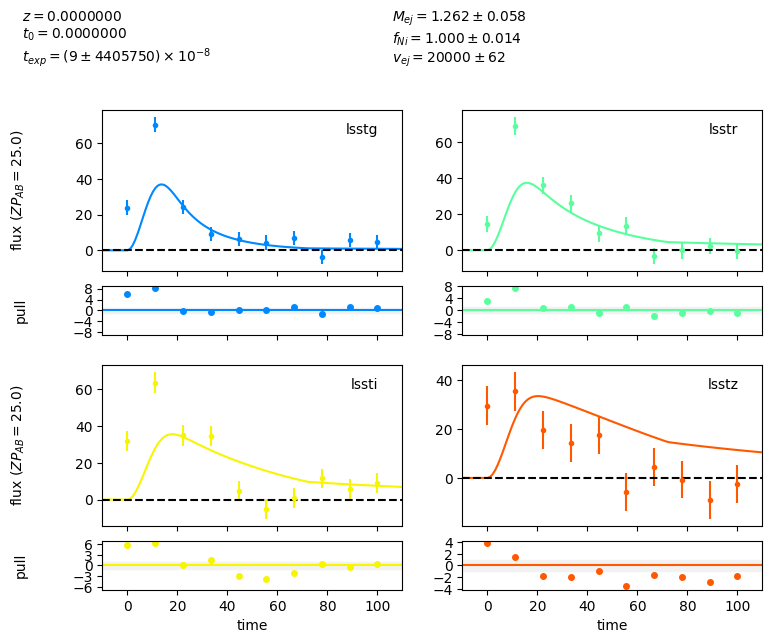

In [28]:
ibc_result, ibc_fitted_model = fit_ibc(0.177,light_curve)
sncosmo.plot_lc(light_curve[0], model=ibc_fitted_model, errors=ibc_result.errors);

In [29]:
ia_obs

time,band,zp,zpsys,gain,skynoise
float64,str5,float64,str2,float64,float64
0.01,lsstg,28.51,ab,1.0,100.0
11.12,lsstg,28.51,ab,1.0,100.0
22.23,lsstg,28.51,ab,1.0,100.0
33.339999999999996,lsstg,28.51,ab,1.0,100.0
44.449999999999996,lsstg,28.51,ab,1.0,100.0
55.559999999999995,lsstg,28.51,ab,1.0,100.0
66.67,lsstg,28.51,ab,1.0,100.0
77.78,lsstg,28.51,ab,1.0,100.0
88.89,lsstg,28.51,ab,1.0,100.0


In [30]:
num_to_fit = 100

fits = {'true_z': [], 'true_t0': [], 'true_x0': [], 'true_x1':[], 'true_c':[], 'fit_t0':[], 'fit_x0':[], 'fit_x1':[], 'fit_c':[]}

# t0 = 20

start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    
    if true_z > 0.2:
        continue
    # try:
    this_t0 = np.random.normal(14., 7.)
    print(true_z, this_t0)
    lcs = simulate_ia(true_z, this_t0, x0, x1, c)

    result, model = fit_ia(true_z, lcs)

    result_dict = sncosmo.flatten_result(result)
    fits['true_z'].append(true_z)
    fits['true_t0'].append(this_t0)
    fits['true_x0'].append(x0)
    fits['true_x1'].append(x1)
    fits['true_c'].append(c)
    fits['fit_t0'].append(result_dict['t0'])
    fits['fit_x0'].append(result_dict['x0'])
    fits['fit_x1'].append(result_dict['x1'])
    fits['fit_c'].append(result_dict['c'])
    # except:
    #     print(true_z)
    #     print("Did not work")

    if len(fits['fit_x0']) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

0.072 6.882857099188088
SNR: 27.33226166985229
0.177 10.62697169490705
SNR: 3.8577691598156973
0.182 14.172852465602336
SNR: 6.147972736855088
0.188 20.93063860625804
SNR: 7.41068342052665
0.147 -2.7246176966787523
SNR: 7.0776405433496254
0.103 16.612606460087825
SNR: 12.50072585631619
0.187 2.20834884818575
SNR: 4.687150936748326
0.138 19.209334167081458
SNR: 10.169795181026421
0.16 0.47035424887882904
SNR: 8.220617158852999
0.1 11.043691377541254
SNR: 13.933241921402862
0.176 18.569687998377226
SNR: 10.574488072883934
0.18 16.57963390746522
SNR: 6.467098421178193
0.127 20.211939686977466
SNR: 12.837803707023046
0.103 20.515879446501103
SNR: 17.4528674188438
0.131 2.206309492851398
SNR: 7.953712890726503
0.18 23.567822664618546
SNR: 6.856162302875667
0.151 15.15131983495139
SNR: 9.110992740084944
0.19 13.278718695884718
SNR: 3.96295730412513
0.147 22.034841717200145
SNR: 8.800849310327507
0.087 6.121358649263378
SNR: 26.725044708637437
0.092 9.678238345693469
SNR: 20.186645977604726
0

Text(0, 0.5, 'Fit t0')

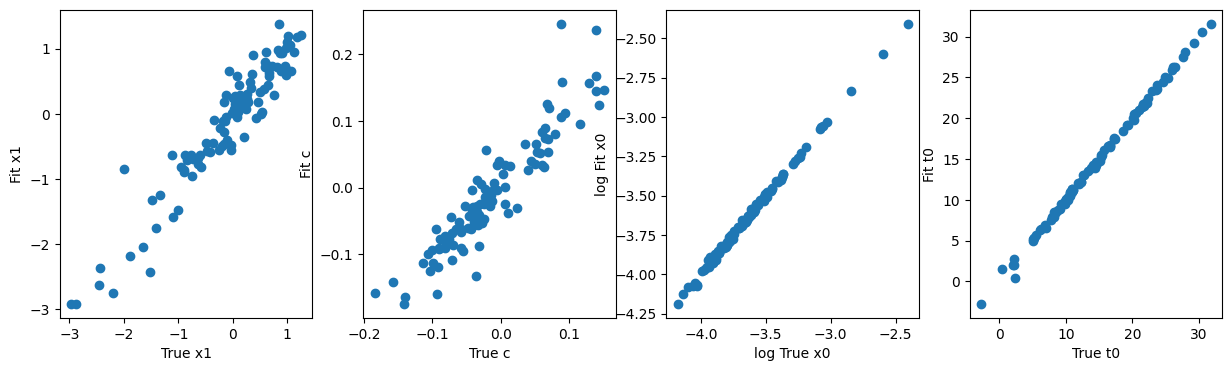

In [31]:
fig, ax = plt.subplots(1,4, figsize=(15, 4))

ax[0].plot(fits['true_x1'], fits['fit_x1'], 'o')
ax[0].set_xlabel("True x1")
ax[0].set_ylabel("Fit x1")
ax[1].plot(fits['true_c'], fits['fit_c'], 'o')
ax[1].set_xlabel("True c")
ax[1].set_ylabel("Fit c")
ax[2].plot(np.log10(fits['true_x0']), np.log10(fits['fit_x0']), 'o')
ax[2].set_xlabel("log True x0")
ax[2].set_ylabel("log Fit x0")
ax[3].plot(fits['true_t0'], fits['fit_t0'], 'o')
ax[3].set_xlabel("True t0")
ax[3].set_ylabel("Fit t0")

In [32]:
class SN:
    ia_keys = ['z', 't0', 'x0', 'x1', 'c']
    ibc_keys = ['z', 'texp', 'mej', 'fni', 'vej']
    ia_fit = {key:None for key in ia_keys}
    ibc_fit = {key:None for key in ibc_keys}
    
    def __init__(self, true_class, true_dict):
        self.true_class = true_class
        if self.true_class == 'ia':
            self.true_params = {key:true_dict[key] for key in self.ia_keys}
        elif self.true_class == 'ibc':
            self.true_params = {key:true_dict[key] for key in self.ibc_keys}
        else:
            raise ValueError("SN has to be either ia or ibc")
            
    def fit_as_ia(self, results_dict):
        self.ia_fit = {key:results_dict[key] for key in self.ia_keys[1:]}
    
    def fit_as_ibc(self, results_dict):
        self.ibc_fit = {key:results_dict[key] for key in self.ibc_keys[1:]}
            


In [33]:
SN('ia', {'z':0.6, 't0':20, 'x0':1e-5, 'x1':0.1, 'c':0.1}).true_class

'ia'

In [34]:
num_to_fit = 100

# t0 = 20

true_ia_sne = []

# fit true Ias as both
start = time.time()
for true_z, mb, x1, c in zip(ia_df['true_z'].to_numpy(), ia_df['salt2_mb'].to_numpy(), ia_df['salt2_x1'].to_numpy(), ia_df['salt2_color'].to_numpy()):
    x0 = get_x0(mb)
    if true_z > 0.2:
        continue
    
    try:
        this_t0 = np.random.normal(14., 7.)
        print(true_z, this_t0)
        
        true_dict = {'z': true_z, 't0':this_t0, 'x0':x0, 'x1':x1, 'c':c}
        this_sn = SN('ia', true_dict)

        lcs = simulate_ia(true_z, this_t0, x0, x1, c)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask]) 
        if snr < 5.0 or snr > 10:
            print("Wrong SNR:", snr)
            continue

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)
        # print(sncosmo.flatten_result(ibc_result))
        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))

        true_ia_sne.append(this_sn)
    except Exception as e:
        print(e)

    if len(true_ia_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)


0.072 6.126761444070681
SNR: 27.384983275555083
Wrong SNR: 27.384983275555083
0.177 10.161181443836343
SNR: 4.011107474209331
Wrong SNR: 4.011107474209331
0.182 17.97703623309436
SNR: 5.736890655508339
Trying again...
0.188 20.50147895565017
SNR: 7.835725737782769
Trying again...
0.147 11.74264967831461
SNR: 9.599813492465191
0.103 21.258201224792103
SNR: 12.31957559067207
Wrong SNR: 12.31957559067207
0.187 15.948662762629551
SNR: 4.676441947641833
Wrong SNR: 4.676441947641833
0.138 12.086572836189001
SNR: 10.496359308549971
Wrong SNR: 10.496359308549971
0.16 11.376387281182673
SNR: 9.968876793690812
Trying again...
0.1 21.28820922821185
SNR: 13.853230066326702
Wrong SNR: 13.853230066326702
0.176 20.528192735350075
SNR: 10.675072026623493
Wrong SNR: 10.675072026623493
0.18 0.7987372725284896
SNR: 5.952702557193817
Trying again...
0.127 17.07302903963109
SNR: 13.33317947106122
Wrong SNR: 13.33317947106122
0.103 10.906836646499942
SNR: 16.553783577813697
Wrong SNR: 16.553783577813697
0.1

/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in exp
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/anasofiauzsoy/anaconda/envs/py310_clone/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


`y` must contain only finite values.
0.198 9.523753317069371
SNR: 6.008846720217846
0.175 1.4998428895002327
SNR: 5.6066810116872166
0.189 13.544093291109785
SNR: 5.822650928850542
0.141 14.691575801098859
SNR: 9.829908006510143
0.115 19.32720621816904
SNR: 15.25897946773921
Wrong SNR: 15.25897946773921
0.154 24.210414216355208
SNR: 8.110301384401112
0.183 20.90718112173424
SNR: 8.28735831868386
0.131 9.584886080391342
SNR: 12.872693814739065
Wrong SNR: 12.872693814739065
0.188 12.575375130926439
SNR: 5.24955009119834
Trying again...
0.078 19.55821212874488
SNR: 24.356319090985956
Wrong SNR: 24.356319090985956
0.191 15.059639802053093
SNR: 7.048300704769891
0.176 14.819156591214671
SNR: 9.445381268192532
0.198 18.88606393471509
SNR: 5.220804132453937
0.116 16.51344552492561
SNR: 10.704898097784561
Wrong SNR: 10.704898097784561
0.091 10.361530612596761
SNR: 19.31833105435846
Wrong SNR: 19.31833105435846
0.133 11.769463437029383
SNR: 11.965156346323496
Wrong SNR: 11.965156346323496
0.11 

In [35]:
true_ibc_sne = []

# Fit ibc as both
start = time.time()
# for index, row in ibc_df.iterrows():
for true_z, mej, fni, k_energy in zip(ibc_df['true_z'].to_numpy(), ibc_df['Mejecta'].to_numpy(), ibc_df['F_nickel'].to_numpy(), ibc_df['Kinetic_energy'].to_numpy()):
    k_energy *=  1e51 * u.erg
    vej = (((2 * k_energy / (mej * u.Msun))**0.5).to(u.km / u.s)).value
    
    if true_z > 0.2 or vej > 20000:
        continue

    print(mej, fni, vej)

    
    try:
        this_texp = np.random.uniform(0., 7.)

        true_dict = {'z': true_z, 'texp': this_texp, 'mej':mej, 'fni':fni, 'vej':vej}
        this_sn = SN('ibc', true_dict)
        
        lcs = simulate_ibc(true_z, this_texp, mej, fni, vej)
        r_band_mask = lcs[0]['band'] == 'lsstr'

        snr = np.mean(np.abs(lcs[0]["flux"][r_band_mask]) / lcs[0]["fluxerr"][r_band_mask]) 
        if snr < 5.0 or snr > 10:
            print("Wrong SNR:", snr)
            continue

        ia_result, _ = fit_ia(true_z, lcs)

        this_sn.fit_as_ia(sncosmo.flatten_result(ia_result))

        ibc_result, _ = fit_ibc(true_z, lcs)

        this_sn.fit_as_ibc(sncosmo.flatten_result(ibc_result))
        true_ibc_sne.append(this_sn)

    except Exception as e:
        print(e)

    if len(true_ibc_sne) == num_to_fit:
        break
    
print((time.time() - start)/num_to_fit)

9.8016 0.0245 9565.13884330619
SNR: 5.864870280776094
1.904 0.0166 16348.990983769314
SNR: 1.6006515785311322
Wrong SNR: 1.6006515785311322
1.0118 0.0617 15126.84991592506
SNR: 3.124715331234453
Wrong SNR: 3.124715331234453
7.6253 0.0184 4905.6166488100735
SNR: 3.592515912769598
Wrong SNR: 3.592515912769598
2.5761 0.0146 15028.819140533313
SNR: 3.497103891977271
Wrong SNR: 3.497103891977271
1.7163 0.0156 14248.0156368035
SNR: 1.0843702462966716
Wrong SNR: 1.0843702462966716
7.9896 0.0192 7171.612516212528
SNR: 3.888559914365456
Wrong SNR: 3.888559914365456
5.4863 0.0456 10416.298485236222
SNR: 5.333482030220602
9.8016 0.0245 9565.13884330619
SNR: 4.918029254176373
Wrong SNR: 4.918029254176373
7.124 0.0112 7986.630416412141
SNR: 2.7853542830769595
Wrong SNR: 2.7853542830769595
1.5546 0.0576 10136.265091056046
SNR: 3.0030315715335885
Wrong SNR: 3.0030315715335885
6.1382 0.0252 10823.865766773122
SNR: 3.8283685160863064
Wrong SNR: 3.8283685160863064
3.9105 0.0121 7621.265636557195
SNR: 1.

In [38]:
np.savez("fitted_sne_100_091025.npz", ia=true_ia_sne, ibc=true_ibc_sne)

In [69]:
all_sne = true_ia_sne + true_ibc_sne
fit_x1 = [sn.ia_fit['x1'] for sn in all_sne]
fit_t0 = [sn.ia_fit['t0'] for sn in all_sne]
fit_c = [sn.ia_fit['c'] for sn in all_sne]
fit_x0 = [sn.ia_fit['x0'] for sn in all_sne]
fit_mej = [sn.ibc_fit['mej'] for sn in all_sne]
fit_fni = [sn.ibc_fit['fni'] for sn in all_sne]
fit_vej = [sn.ibc_fit['vej'] for sn in all_sne]

(array([  2.,   1.,  36., 100.,  45.,  14.,   1.,   0.,   0.,   1.]),
 array([-34.6183492 , -19.38534662,  -4.15234404,  11.08065854,
         26.31366113,  41.54666371,  56.77966629,  72.01266887,
         87.24567145, 102.47867404, 117.71167662]),
 <BarContainer object of 10 artists>)

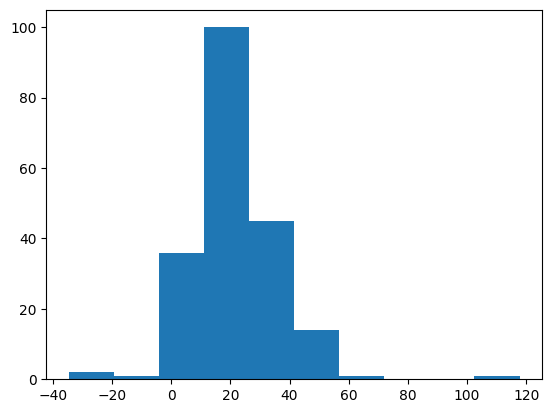

In [70]:
plt.hist(fit_t0)

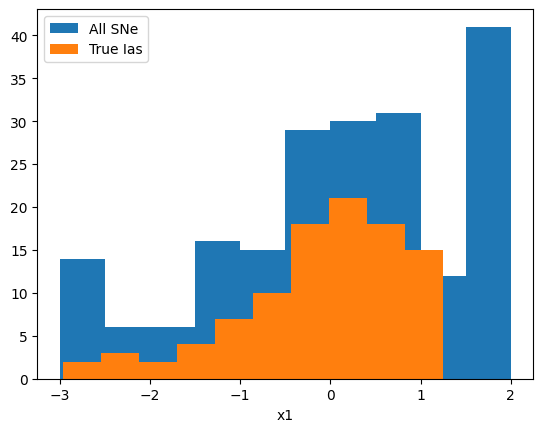

In [71]:
plt.hist(fit_x1, label="All SNe")
plt.hist([sn.true_params['x1'] for sn in true_ia_sne], label="True Ias")
plt.xlabel("x1")
plt.legend()

In [ ]:
sn.true_params

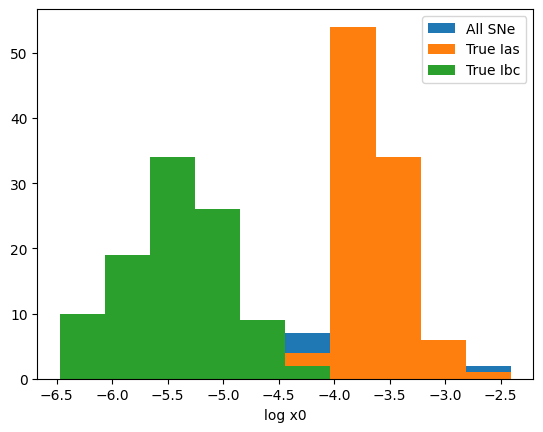

In [74]:
_, bins, _ = plt.hist(np.log10(fit_x0), label="All SNe")
plt.hist(np.log10([sn.true_params['x0'] for sn in true_ia_sne]), label="True Ias", bins=bins)
plt.hist(np.log10([sn.ia_fit['x0'] for sn in true_ibc_sne]), label="True Ibc", bins=bins)

plt.xlabel("log x0")
plt.legend()

In [75]:
ibc_mask = [sn in true_ibc_sne for sn in all_sne]

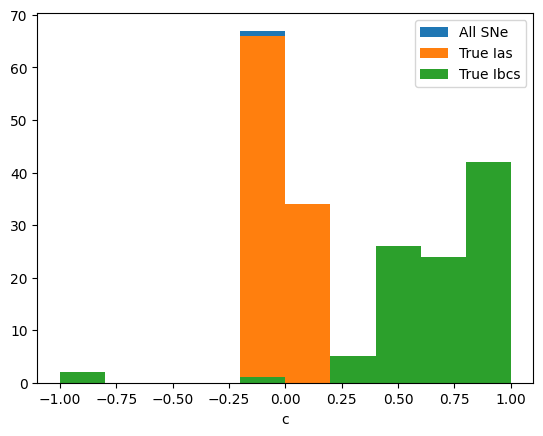

In [76]:
_, bins, _ = plt.hist(fit_c, label="All SNe")
plt.hist([sn.true_params['c'] for sn in true_ia_sne], label="True Ias", bins=bins)
plt.hist(fit_c[(len(fit_c)//2):len(fit_c)], label="True Ibcs", bins=bins)

plt.xlabel("c")
plt.legend()

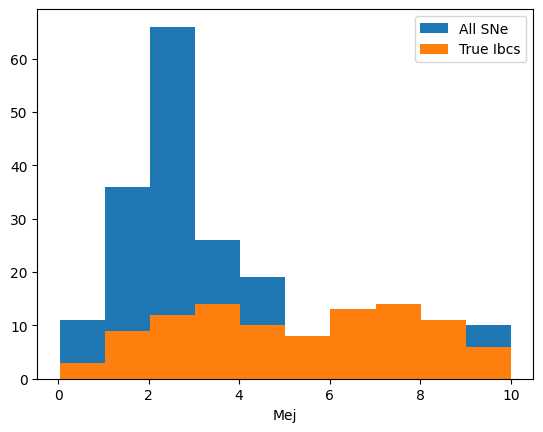

In [77]:
_, bins, _ = plt.hist(fit_mej, label="All SNe")
plt.hist([sn.true_params['mej'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

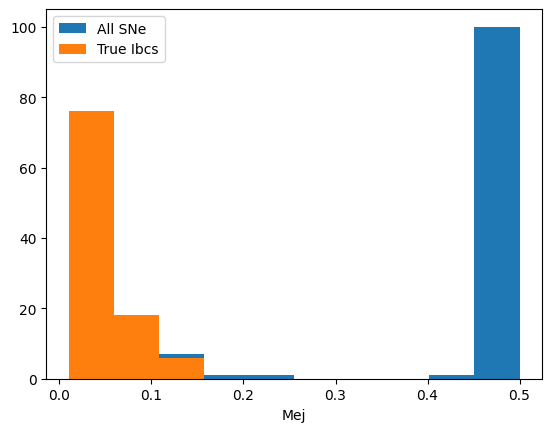

In [78]:
_, bins, _ = plt.hist(fit_fni, label="All SNe")
plt.hist([sn.true_params['fni'] for sn in true_ibc_sne], label="True Ibcs", bins=bins)
plt.xlabel("Mej")
plt.legend()

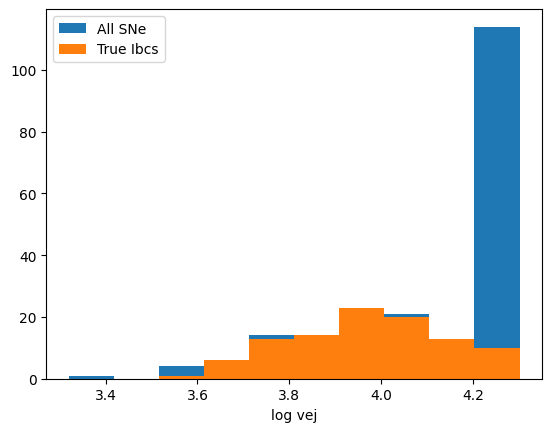

In [79]:
_, bins, _ = plt.hist(np.log10(fit_vej), label="All SNe")
plt.hist(np.log10([sn.true_params['vej'] for sn in true_ibc_sne]), label="True Ibcs", bins=bins)
plt.xlabel("log vej")
plt.legend()